In [ ]:
!pip install -q git+https://www.github.com/MaxiLechner/neural-quantum-states#egg=nqs

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
from pylab import rcParams
rcParams['figure.figsize'] = 6.4 * 1.5, 4.8 * 1.5
rcParams['lines.linewidth'] = 1.5
plt.style.use('ggplot')

In [3]:
from nqs.hamiltonian import initialize_model_1d

import jax
import jax.numpy as np

from jax.experimental import optimizers

import numpy as onp
from time import time
from pathlib import Path
import warnings
from absl import app, flags

In [4]:
def plot(data):
    E, mag, E_var, gs_energy = data
    fig, ax = plt.subplots(1,2,figsize=(6.4 * 2.5, 4.8 * 1.5))
    e = np.array(E).real.mean(axis=1)
    ax[0].plot(e, label='energy')
    ax[0].axhline(gs_energy, label='exact energy',linestyle=':', color="r")
    ax[0].plot(mag, label='magnetization')

    ax[1].semilogy(E_var, label='Energy variance') 

    ax[0].set_xlabel(r'Training step', fontsize = 25)
    ax[1].set_xlabel(r'Training step', fontsize = 25)
    ax[0].legend()
    ax[1].legend()
    plt.tight_layout()
    plt.show()

In [210]:
pbc = False
x64 = False
one_hot = False # use one_hot encoding or not, e.g spins are represented by -1,1 or (1,0),(0,1)

hamiltonian = "ising_1d" # "heisenberg_1d" | "ising_1d" | "J1J2_1d"
J = 1.0 # nearest neighbor coupling parameter
J2 = 0.2 # next nearest neighbor coupling parameter, only used for J1J2 model

epochs = 5000
lr = 1e-03
learning_rate_fn = lr # optimizers.exponential_decay(lr,epochs-2000,0.005)
learning_rate_fn = optimizers.make_schedule(learning_rate_fn)
print_every = 200

network = "lstm" # "conv" | "lstm"
batch_size = 50
num_spins = 10
seed = 0
depth = 1 # depth of network
width = 32 # width/number of channels of convolution
filter_size = 5 # filter_size of convolution
hidden_size = 16 # hidden size of lstm

if hamiltonian == "heisenberg_1d":
    if pbc:
        if J == 1:
            gs_energy = num_spins * (1 / 4 - np.log(2))
        elif J < 0:
            gs_energy = J * num_spins / 4
    elif not pbc and num_spins == 16:
        gs_energy = -6.9117371455749
    else:
        gs_energy = np.nan

elif hamiltonian == "ising_1d":
    if pbc is False:
        gs_energy = 1 - 1 / (np.sin(np.pi / (2 * (2 * num_spins + 1))))
    else:
        gs_energy = np.nan
        
elif hamiltonian == "J1J2_1d" and num_spins == 10 and J == 1. and J2 == 0.2 and pbc is False:
    gs_energy = -3.9855798336170905

In [211]:
def sqrt_decay(init,i):
    return init/np.sqrt(1 + 0.005*i)

In [212]:
step, key, energy_fn, init_batch, optimizer = initialize_model_1d(hamiltonian,width,filter_size,seed,num_spins,lr,J,J2,batch_size,hidden_size,depth,pbc,network,x64=x64,one_hot=one_hot)

E = []
mag = []
E_var = []
learning_rate = []

lr_init = lr

old_time = time()
for i in range(epochs):
    lr = sqrt_decay(lr_init,i)
    optimizer, key, energy, magnetization, var = step(optimizer, key, lr, init_batch)
    
    E.append(energy)
    mag.append(magnetization)
    E_var.append(var)
    learning_rate.append(lr)
        
    if i == 1:
        new_time = time()
        print("{}\t{}\t{}\t{}\t{}".format("Step","Energy","Mag","Var","Time/Step"))
        print("-----------------------------------------")
        print("{}\t{:.2f}\t{:.2f}\t{:.3f}\t{:.2f}".format(i, energy.real.mean(), magnetization, var.real, new_time - old_time))
        old_time = new_time
    if i % print_every == 0 and i > 0 or i == epochs-1:
        new_time = time()
        print("{}\t{:.2f}\t{:.2f}\t{:.3f}\t{:.2f}".format(i, energy.real.mean(), magnetization, var.real, new_time - old_time))
        old_time = new_time

data = (E,mag,E_var,gs_energy)
k = 100 
print("Ground state energy = ", onp.mean([i.real for i in E[-k:]]), "+-", np.sqrt(np.max(E_var[-k:])/(batch_size*k)))
print("Exact energy =        ", gs_energy)

Step	Energy	Mag	Var	Time/Step
-----------------------------------------
1	-11.45	6.92	2.008	40.05
200	-11.92	6.92	0.311	1.55
400	-12.44	4.76	0.183	1.27
600	-12.34	3.08	0.088	1.33
800	-12.33	0.64	0.024	1.51
1000	-12.42	0.28	0.019	1.28
1200	-12.38	1.40	0.012	1.73
1400	-12.44	0.56	0.006	1.56
1600	-12.39	2.00	0.006	1.31
1800	-12.38	2.08	0.002	1.65
2000	-12.40	1.08	0.003	1.31
2200	-12.38	0.76	0.002	1.31
2400	-12.38	0.68	0.002	1.78
2600	-12.38	0.40	0.002	1.64
2800	-12.39	1.52	0.002	2.66
3000	-12.35	0.48	0.001	2.47
3200	-12.38	0.60	0.001	1.83
3400	-12.38	0.24	0.002	1.30
3600	-12.39	0.40	0.001	1.96
3800	-12.39	0.64	0.001	1.44
4000	-12.40	1.04	0.001	1.34
4200	-12.37	0.20	0.001	1.39
4400	-12.40	0.76	0.001	1.36
4600	-12.39	0.64	0.001	1.32
4800	-12.37	0.56	0.001	1.55
4999	-12.38	-0.32	0.001	1.70
Ground state energy =  -12.3819895 +- 0.0005756937
Exact energy =         -12.381489


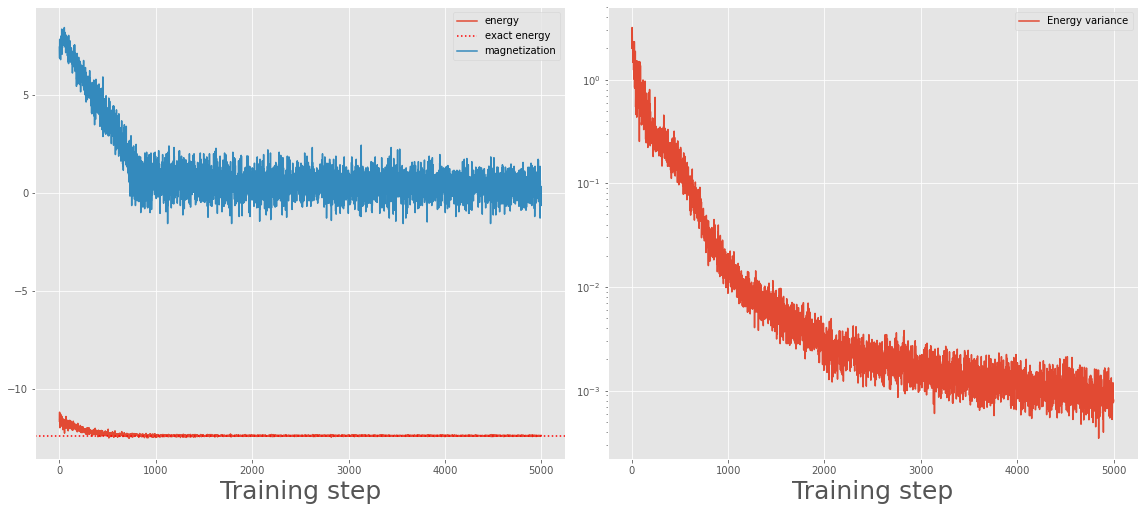

In [214]:
plot(data)